In [16]:
import pandas as pd
import json  
from pandas.io.json import json_normalize 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use("ggplot")

# Calculate Bitcoin Market Capitalization Dominance from 2020-01-01

In [4]:
import urllib.request
url = "https://api.nomics.com/v1/market-cap/history?key=7b5a32aeef57b5385383f0225ec93d50&start=2020-01-01T00%3A00%3A00Z"
total_cap = urllib.request.urlopen(url).read()
total_market_cap_df = pd.read_json(total_cap)  #reading json data for total market cap into a pandas dataframe

In [5]:
total_market_cap_df.rename(columns={"market_cap": "total_market_cap"}, inplace=True) # renaming columns

In [43]:
btc_df = pd.read_csv("btc-data.csv") # reading bitcoin data into a pandas df
btc_df = btc_df[btc_df['snapped_at'] >= "2020-01-01 00:00:00"]   # chopping off data before Jan 2020
btc_df.drop(["total_volume", "price"], axis = 1, inplace = True)
btc_df["market_cap"] = btc_df["market_cap"].apply(lambda x: '{:.2f}'.format(x)).astype(float).astype(int)  # supressing scientific notations

In [44]:
# concatenating two dfs to calculate bitcoin market capitalization dominance 
total_market_cap_df.reset_index(drop=True, inplace=True)
btc_df.reset_index(drop=True, inplace=True)
btc_dominance_df = pd.concat([total_market_cap_df, btc_df],axis = 1)  

In [45]:
btc_dominance_df["btc_dominance"] = (btc_dominance_df["market_cap"] / btc_dominance_df["total_market_cap"]) * 100 # dominance % column generated

btc_dominance_df["timestamp"] = btc_dominance_df["timestamp"].dt.date  # keeping only date part from timestamp

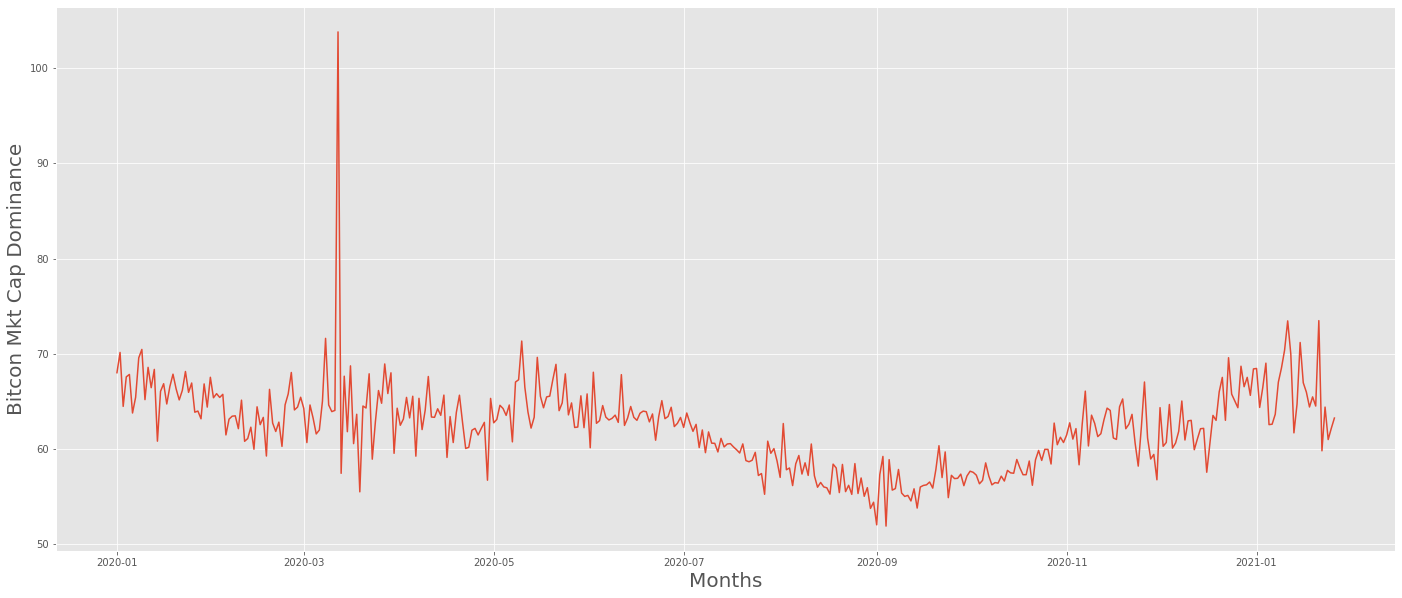

In [56]:
figure(figsize=(24, 10))
plt.xlabel("Months", size = 20)
plt.ylabel("Bitcon Mkt Cap Dominance", size = 20)
_ = plt.plot(btc_dominance_df["timestamp"],btc_dominance_df["btc_dominance"] )

### Justification for the spike

As we can see that the market cap dominance sometime in March is > 100%, which is an anomaly. The reason for the anomaly is the fact that I had to pull the BTC MarketCap and the Total Market Cap of all crypto currencies from different data sources, which might not be in sync.

# Calculate the daily ETHBTC ratio for the last month

In [21]:
btc_data = pd.read_csv("btc-data.csv") # reading bitcoin data into a pandas df
btc_df_30 = btc_data[btc_data['snapped_at'] >= "2020-12-26 00:00:00"] # keeping relavant rows
btc_df_30 = btc_df_30[["snapped_at", "price"]]  # keeping relavant columns
btc_df_30.rename(columns={"price": "btc_price"}, inplace=True)  # renaming columns

In [22]:
eth_df = pd.read_csv("eth-usd-max.csv") # reading ethereum data into a pandas df
eth_df_30 = eth_df[eth_df['snapped_at'] >= "2020-12-26 00:00:00"] # keeping relavant rows
eth_df_30 = eth_df_30[["snapped_at", "price"]] # keeping relavant columns
eth_df_30.rename(columns={"price": "eth_price"}, inplace=True)  # renaming columns

In [23]:
eth_btc_df = pd.merge(btc_df_30, eth_df_30, on=['snapped_at']) # merging dfs on date

In [24]:
eth_btc_df["eth_btc_raio"] = eth_btc_df["eth_price"] / eth_btc_df["btc_price"] # adding column for ethbtc ratio

In [30]:
eth_btc_df["snapped_at"] = eth_btc_df["snapped_at"].apply(lambda x: x[:-3])  # fixing keys to be in required format
ethbtc_ratio_dict = dict(zip(eth_btc_df["snapped_at"],eth_btc_df["eth_btc_raio"])) # making dictionary

In [31]:
ethbtc_ratio_dict

{'2020-12-26 00:00:00 ': 0.025392323118609502,
 '2020-12-27 00:00:00 ': 0.024049674703184552,
 '2020-12-28 00:00:00 ': 0.026100514163444773,
 '2020-12-29 00:00:00 ': 0.02702107465234019,
 '2020-12-30 00:00:00 ': 0.026822361512809006,
 '2020-12-31 00:00:00 ': 0.026107029157508534,
 '2021-01-01 00:00:00 ': 0.025449875613107062,
 '2021-01-02 00:00:00 ': 0.02487544924410421,
 '2021-01-03 00:00:00 ': 0.024179215838523158,
 '2021-01-04 00:00:00 ': 0.02929574557467813,
 '2021-01-05 00:00:00 ': 0.032544376426817866,
 '2021-01-06 00:00:00 ': 0.03237343997142801,
 '2021-01-07 00:00:00 ': 0.03272298682551037,
 '2021-01-08 00:00:00 ': 0.03108879816487932,
 '2021-01-09 00:00:00 ': 0.029981645237404573,
 '2021-01-10 00:00:00 ': 0.031838463690145646,
 '2021-01-11 00:00:00 ': 0.03301563720138837,
 '2021-01-12 00:00:00 ': 0.030639674711853172,
 '2021-01-13 00:00:00 ': 0.030803125379667576,
 '2021-01-14 00:00:00 ': 0.03022253731131651,
 '2021-01-15 00:00:00 ': 0.03101783049494257,
 '2021-01-16 00:00:00 

**Question** Assume that we must calculate the ETHBTC ratio per minute (1,440 times per day), and insert the new ratio to a SQL database. How would you automate, and host this ETL workflow to run per minute and what services would you use?

**Answer** We will need an API partner to provide us the minute based ETH and BTC price breakdown. Then we will need a cron job to query the service every minute and persist the price to mysql using the sql APIs.
Instead of a CronJob, we can also create a polling service that polls the API and persists the data every minute using the sql API. The polling service would just query the API, persist the data and sleep for a minute before coming back up again and doing the same thing.